In this project we will use :

*   Deep learning Library : TensorFlow
*   Modeling toolset (fast experiment with DNN): Keras

GoogleCollab need the necessary libraries installed and configured to use GPUs. (https://colab.research.google.com/drive/1FKH1dnzzyzC4qoIlmHHNObvng7ztDJhJ?usp=sharing)

In practice, one might consider that solving this project essentially amounts to follow carefully this tutorial (with one important modification regarding how the training is done) It is highly recommended however not to follow it blindly. Please do consider carefully all the following hints.
(https://inginious.info.ucl.ac.be/course/LINFO2263/project3a/tuto.pdf)


HINT:
*   A particularly handy way to split your work, and to avoid re-doing everything from scratch if one step fails or has not been implemented yet, is to serialize python objects. This is one convenient way to save into a (binary) file some objects from a python session and to load them back when restarting a new python session. A handy module to serialize python objects is pickle. (https://docs.python.org/3.8/library/pickle.html?highlight=pickle#module-pickle)
*   Several Keras or Tensorflow objects cannot be serialized as mentioned before since pickle is essentially designed for standard python data structures such as lists or dictionaries. Fortunately, some specific alternatives exist as the keras model saving or tensorflow save and load. (https://keras.io/api/models/model_saving_apis/) (https://www.tensorflow.org/tutorials/keras/save_and_load)

In [ ]:
# Mount my google drive and make it acessible as if it were a local file system
from google.colab import drive
drive.mount('/content/drive')

# corpus = "/content/drive/MyDrive/Colab Notebooks/LINFO2263_P3/fra_eng.txt"
# with open(corpus) as f:
#    for line in f:
#       print(line)

Mounted at /content/drive


Following code could not work for the moment but it will help us a lot. In fact, we will have to create a 3D tensor corresponding to the list of "one-hot" encoded output sentences. But these are a lot to stock (several Gb) so we use a lazy implementation : Tensorflow.keras.utils.Sentence (https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)

Here start the following of the tutorial (https://inginious.info.ucl.ac.be/course/LINFO2263/project3a/tuto.pdf).

Seq2seq architecture used for Text-Summarization,
chatbot development, conversational modeling, and neural machine
translation, etc.

Here we will see how to create a language translation.

Seq2seq is encoder-decoder using two LSTM:
*   Input -> encoder : Sentence in original language.
*   Input -> decoder : Sentence in translated language with token start.
*   Output is the actual target sentence with an end-of-sentence token.



In [ ]:
import os, sys
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow.keras.utils import plot_model
import tensorflow
import numpy as np
from tensorflow.keras.utils import Sequence
from numpy.random           import seed
from tensorflow.random      import set_seed

BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES = 256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 50
VALIDATION_SPLIT = 0.1

ImportError: ignored

In [ ]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
# Data Preprocessing
for line in open(r'/content/drive/MyDrive/Colab Notebooks/LINFO2263_P3/fra_eng.txt', encoding="utf-8"):
# for line in open(r'/home/thomas/Bureau/fra_eng.txt', encoding="utf-8"):
  count += 1
  if count > NUM_SENTENCES:
    break
  if '\t' not in line:
    continue

  input_sentence, output, _ = line.rstrip().split('\t')

  output_sentence = output + ' <eos>'
  output_sentence_input = '<sos> ' + output

  input_sentences.append(input_sentence)
  output_sentences.append(output_sentence)
  output_sentences_inputs.append(output_sentence_input)

# print("num samples input:", len(input_sentences))
# print("num samples output:", len(output_sentences))
# print("num samples output input:", len(output_sentences_inputs), '\n')

print("Question 3.1.1:")
print(input_sentences[172])
print(output_sentences[172])
print(output_sentences_inputs[172] + "\n")

# Tokenization and padding

input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
word2idx_inputs = input_tokenizer.word_index
max_input_len = max(len(sen) for sen in input_integer_seq)

print("Question 3.1.2:")
print('Total unique words in the input: %s' % len(word2idx_inputs))
print("Length of longest sentence in input: %g \n" % max_input_len)

output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
word2idx_outputs = output_tokenizer.word_index
num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)

print("Question 3.1.3")
print('Total unique words in the output: %s' % len(word2idx_outputs))
print("Length of longest sentence in the output: %g \n" % max_out_len)

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
encoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_input_len)

#print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
# print("encoder_input_sequences[172]:", encoder_input_sequences[172])
# print(word2idx_inputs["i'm"])
# print(word2idx_inputs["hit"])
# print("")

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

#print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
# print("decoder_input_sequences[172]:", decoder_input_sequences[172])
# print("")
# print([word2idx_outputs["<sos>"], word2idx_outputs["je"], word2idx_outputs["suis"], word2idx_outputs["touchée"], word2idx_outputs["!"]])

Question 3.1.1:
I'm hit!
Je suis touchée ! <eos>
<sos> Je suis touchée !

Question 3.1.2:
Total unique words in the input: 3511
Length of longest sentence in input: 6 

Question 3.1.3
Total unique words in the output: 9523
Length of longest sentence in the output: 13 



In [ ]:
# Words embeddings

embeddings_dictionary = dict()
glove_file = open(r'/content/drive/MyDrive/Colab Notebooks/LINFO2263_P3/glove.6B.50d.txt', encoding="utf8")
# glove_file = open(r'/home/thomas/Bureau/glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dictionary[word] = vector_dimensions
glove_file.close()

num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

print("Question 3.1.4:")
print(embeddings_dictionary["hit"][-3:])
# print()
# print(embedding_matrix[615])

embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

Question 3.1.4:
[-0.23663  0.29088  0.11071]


Question 3.1.5
(20000, 13, 9524)


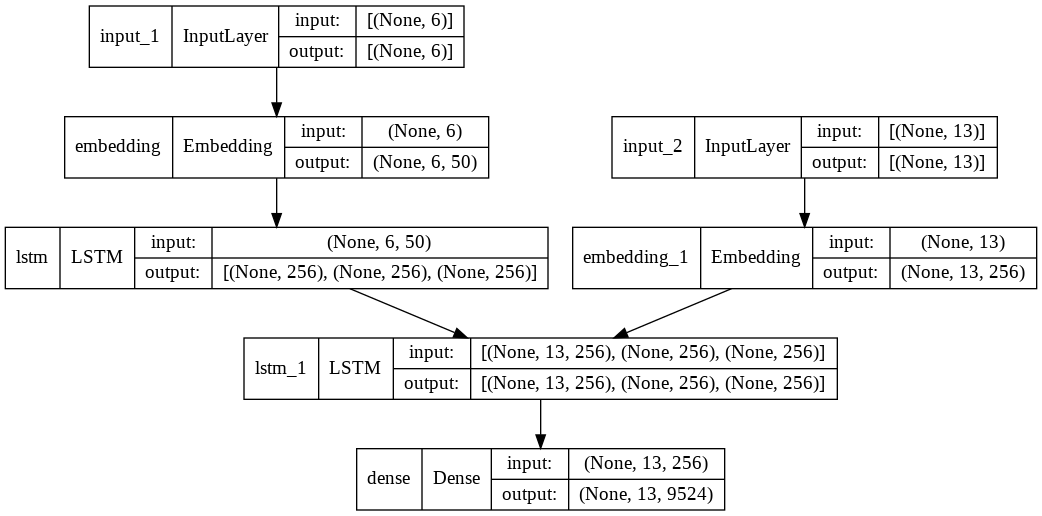

In [ ]:
# Creating the model

decoder_targets_one_hot = np.zeros((
    len(input_sentences),
    max_out_len,
    num_words_output
  ),
  dtype='float32')

print("Question 3.1.5")
print(decoder_targets_one_hot.shape) # Shape of decoder

# Make 1 at column number [2 3 6 188 0 0 0 0 0 0 0] enumerate(row)
# Here we used decoder_input_sequences INSTEAD OF decoder_output_sequences
for i, d in enumerate(decoder_input_sequences):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

# Define encoder : input are sentence in english and output is hidden state
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

# "The following script creates the decoder LSTM:"
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense Layer
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Compile model
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)
model.compile(
 optimizer='rmsprop',
 loss='categorical_crossentropy',
 metrics=['accuracy']
)

# Plot the result
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train model here
#-------------------------------------------------------------------------------
# These steps would not be required if you were developing the auto-translation
# project for yourself. These however, help reducing the variance induced by the
# random neural weights assigned at the beginning of the gradient descent.
# Which is useful when grading your answer
#-------------------------------------------------------------------------------
seed(42)
set_seed(42)
#
#-------------------------------------------------------------------------------
# This sequence is used to feed the training process with batches that are not
# all loaded in ram at once
#------------------------------------------------------------------------------
class LazyLoadedSequence(Sequence):
  def __init__(self, begin, end):
    self.begin      = begin        # beginning (included) of the considered data
    self.end        = end          # end (excluded) of the considered data
    self.nb_samples = end - begin  # number of data samples

  def __len__(self):
    # returns the number of batches of data
    return np.ceil(self.nb_samples / BATCH_SIZE).astype(np.int)

  def __getitem__(self, idx):
    # returns the `idx`th batch of data
    # (returns both inputs aka xs and outputs aka ys)
    start   = self.begin + BATCH_SIZE * idx
    end     = min(self.end, start + BATCH_SIZE)

    enc_x   = encoder_input_sequences[start:end]
    dec_x   = decoder_input_sequences[start:end]
    one_hot = np.zeros((end-start, max_out_len, num_words_output), dtype='float16')
    # now let us actually build the one hot encoded representation for each of
    # the output sentences (in french)
    for i, d in enumerate(decoder_output_sequences[start:end]):
      for t, word in enumerate(d):
        one_hot[i, t, word] = 1
    # now return both the xs and the ys
    return [enc_x, dec_x], one_hot

#-------------------------------------------------------------------------------
# Actually fit it with custom batches
#------------------------------------------------------------------------------
nb_sentences    = len(input_sentences)
split_limit     = np.ceil(nb_sentences * (1 - VALIDATION_SPLIT)).astype(np.int)
train_data      = LazyLoadedSequence(0, split_limit)
validation_data = LazyLoadedSequence(split_limit, nb_sentences)
r = model.fit(
    train_data,
    validation_data = validation_data,
    epochs          = EPOCHS,
)

Epoch 1/20
282/282 [==============================] - 26s 67ms/step - loss: 2.1595 - accuracy: 0.7113 - val_loss: 2.2290 - val_accuracy: 0.6924
Epoch 2/20
282/282 [==============================] - 17s 61ms/step - loss: 1.7616 - accuracy: 0.7377 - val_loss: 2.0339 - val_accuracy: 0.7037
Epoch 3/20
282/282 [==============================] - 17s 60ms/step - loss: 1.6040 - accuracy: 0.7544 - val_loss: 1.9092 - val_accuracy: 0.7150
Epoch 4/20
282/282 [==============================] - 17s 59ms/step - loss: 1.4753 - accuracy: 0.7728 - val_loss: 1.8245 - val_accuracy: 0.7317
Epoch 5/20
282/282 [==============================] - 17s 59ms/step - loss: 1.3699 - accuracy: 0.7886 - val_loss: 1.7487 - val_accuracy: 0.7392
Epoch 6/20
282/282 [==============================] - 17s 59ms/step - loss: 1.2804 - accuracy: 0.8002 - val_loss: 1.7322 - val_accuracy: 0.7446
Epoch 7/20
282/282 [==============================] - 17s 59ms/step - loss: 1.2069 - accuracy: 0.8095 - val_loss: 1.6918 - val_accuracy:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 50)        175600      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 13, 256)      2438144     ['input_2[0][0]']                
                                                                                              

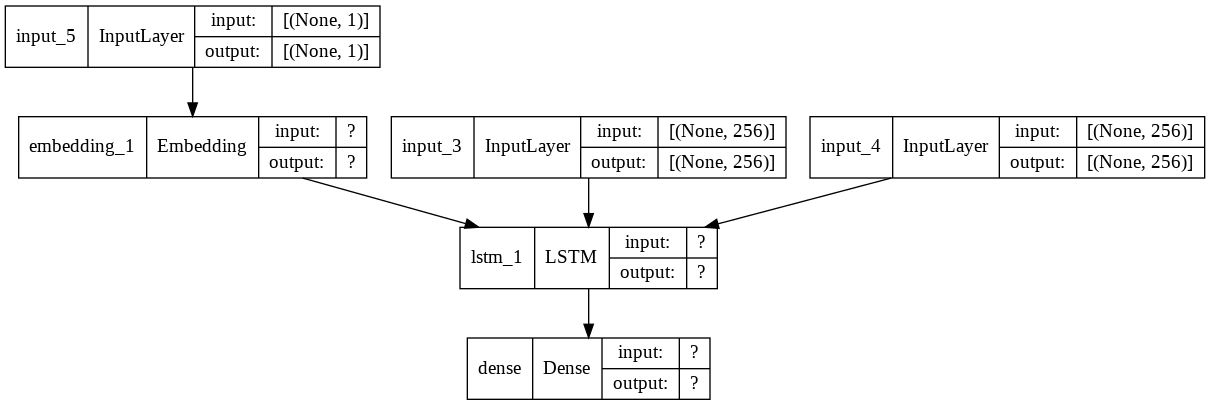

In [ ]:
model.summary()

# Question 3.2.1: 5,901,092 parameters (model.summary())
# Question 3.2.2: val_loss: 1.5528 - val_accuracy: 0.7810
# Question 3.2.3: al_loss: 1.6595 - val_accuracy: 0.7860

# Same encoder
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

# Add hidden & cell state
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Modify decoder embedding layer to fit with only single word now
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# PlaceHolder for decoder outputs
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

# Dense Layer again
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

# Update model of decoder
decoder_model = Model(
 [decoder_inputs_single] + decoder_states_inputs,
 [decoder_outputs] + decoder_states
)

# encoder_model.compile(
#  optimizer='rmsprop',
#  loss='categorical_crossentropy',
#  metrics=['accuracy']
# )

# decoder_model.compile(
#  optimizer='rmsprop',
#  loss='categorical_crossentropy',
#  metrics=['accuracy']
# )

encoder_model.summary()
decoder_model.summary()

# Question 3.2.4: 489,968 (encoder_model.summary())
#                 5,411,124 (decoder_model.summary())

plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [ ]:
def translate_sentence(input_seq, encoder_model, decoder_model, word2idx_outputs, idx2word_target):
  states_value = encoder_model.predict(input_seq)
  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = word2idx_outputs['<sos>']
  eos = word2idx_outputs['<eos>']
  output_sentence = []

  for _ in range(max_out_len):
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    idx = np.argmax(output_tokens[0, 0, :])

    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_target[idx]
      output_sentence.append(word)

    target_seq[0, 0] = idx
    states_value = [h, c]
  return ' '.join(output_sentence)

idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

# sent = "I'm a lawyer."
sent = "Is anybody hurt?"
# sent = "I'm concentrating."
i = 0
while i < len(input_sentences) and input_sentences[i] != sent:
  i+=1
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq, encoder_model, decoder_model, word2idx_outputs, idx2word_target)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)
test = ""
for word in output_sentences[i]:
  test+= word.lower()
print('Expected Response:', test)

-
Input: Is anybody hurt?
Response: quiconque est-il blessé ?
Expected Response: quiconque est-il blessé ? <eos>
[['quiconque', 'est-il', 'blessé', '?', '<eos>']]


In [ ]:
import nltk

reference = [['this', 'looks', 'highly', 'satisfactory', '<eos>'], ['this', 'looks', 'good', 'indeed', '<eos>' ]]
candidate = ['this', 'is', 'very', 'good', 'indeed', '<eos>']

smooth = nltk.translate.bleu_score.SmoothingFunction().method1
print("Question 3.4.1:")
print(round(nltk.translate.bleu_score.sentence_bleu(reference, candidate, smoothing_function=smooth), 3))

def compute_bleu(encoder_input_sequences, encoder_model, decoder_model, word2idx_outputs, idx2word_target, smooth):
    refs = []
    cands = []
    for i in range(18000, 20000):
        temp = translate_sentence(encoder_input_sequences[i:i+1], encoder_model, decoder_model, word2idx_outputs, idx2word_target) + " <eos>"
        refs.append(temp)
        test = ""
        for word in output_sentences[i]:
            test += word.lower()
        cands.append(test)
    refs_ret = []
    cands_ret = []
    for i in range(len(refs)):
        refs_ret.append(refs[i].split(" "))
        cands_ret.append(cands[i].split(" "))
    return round(nltk.translate.bleu_score.sentence_bleu(refs_ret, cands_ret, weights=[0.5, 0.5], smoothing_function=smooth), 3)

Question 3.4.1:
0.217


In [ ]:
#for i in range(2000):
  #print(refs[i] + output_sentences[i+18000])
print(compute_bleu(encoder_input_sequences, encoder_model, decoder_model, word2idx_outputs, idx2word_target, smooth))

# END OF TUTORIAL, OTHER INFORMATION: ==============================

## Step 1: Working with the provided Data

Throughout this project, you will be working with a parallel corpus and a pretrained GloVe embedding. The simplest way of working with this data from your Colab notebook, is to:

1. Create your own notebook. This will save the notebook in your Google Drive, in a folder named _**"Colab Notebooks"**_. 
2. Upload the files _**"fra_eng.txt"**_ and _**"glove.6B.50d.txt"**_ to your Google Drive (using either your browser or your platform specific fat client).
As shown in the picture below, in my case, I created a subfolder named LINFO2263 to hold all the files related to this project.

## Step 2: Hardware acceleration

As you may already know (if not, you will soon !), training neural networks is a computationally very expensive task. This is why using specific hardware is highly beneficial during training (but it is sometimes tricky to get properly configured).  With that respect, Colab provides you with free to use preconfigured hardware you can use to train your models.

In particular, it gives you an opportunity to train your model using either: 

- a CPU (aka Cental Processing Unit; this is your slowest option)
- a GPU (aka Graphical Processing Unit; which is much faster !!)
- a TPU (aka Tensor Processing Unit; even faster, but chances are you won't get access to them since they are allocated to paid customers firts)

By default, your Colab Notebook is running on a session whose python interpreter only uses a CPU (no GPU/TPU available). To change that and use a GPU enabled session you should click on the resources usage summary (top right of this window).

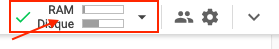

This will open a panel on the left of your browser where you can chose to "Modify execution type". And then select the kind of hardware acceleration you want to use.

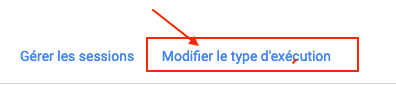

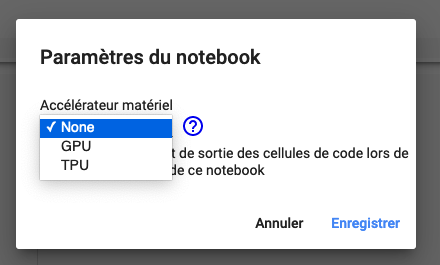

## Step 3: Training your model with a tractable amount of RAM

_**This will be repeated in the INGInious instructions. But we already emphazise on it so you won't glose over that bit when completing your assignment**_ 


If you carefully follow the tutorial, you will see that at some point; the tutorial instructs you to create a 3D tensor corresponding to the list of "one-hot" encoded output sentences. While this approach is feasible in theory, and although the training corpus is pretty small; the amount of memory which is required to store that tensor is not reasonable (several Gb of RAM). And can't therefore be used for practical purposes (not even for the purpose of completing this assignment). This is why we request you to create those one-hot encoded sentences _lazily_ using the following implementation of a `tensorflow.keras.utils.Sentence`. If interested, you will find more information about that class in the [tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence).

In practice, the training step of your model should be done as follows (don't worry, this code does not work right now, but it will when you will have completed the necessary steps of the project) 



In [ ]:
# You should train your neural net model as shown below:
import tensorflow
import numpy as np
from tensorflow.keras.utils import Sequence
from numpy.random           import seed
from tensorflow.random      import set_seed
#-------------------------------------------------------------------------------
# These steps would not be required if you were developing the auto-translation
# project for yourself. These however, help reducing the variance induced by the
# random neural weights assigned at the beginning of the gradient descent.
# Which is useful when grading your answer
#-------------------------------------------------------------------------------
seed(42)
set_seed(42)
#
#-------------------------------------------------------------------------------
# This sequence is used to feed the training process with batches that are not
# all loaded in ram at once
#------------------------------------------------------------------------------
class LazyLoadedSequence(Sequence):
  def __init__(self, begin, end):
    self.begin      = begin        # beginning (included) of the considered data
    self.end        = end          # end (excluded) of the considered data
    self.nb_samples = end - begin  # number of data samples 

  def __len__(self):
    # returns the number of batches of data
    return np.ceil(self.nb_samples / BATCH_SIZE).astype(np.int)
  
  def __getitem__(self, idx):
    # returns the `idx`th batch of data 
    # (returns both inputs aka xs and outputs aka ys)
    start   = self.begin + BATCH_SIZE * idx
    end     = min(self.end, start + BATCH_SIZE)
    #
    enc_x   = encoder_input_sequences[start:end]
    dec_x   = decoder_input_sequences[start:end]
    one_hot = np.zeros((end-start, max_out_len, num_words_output), dtype='float16')
    # now let us actually build the one hot encoded representation for each of
    # the output sentences (in french)
    for i, d in enumerate(decoder_output_sequences[start:end]):
      for t, word in enumerate(d):
        one_hot[i, t, word] = 1
    # now return both the xs and the ys
    return [enc_x, dec_x], one_hot

#-------------------------------------------------------------------------------
# Actually fit it with custom batches
#------------------------------------------------------------------------------
nb_sentences    = len(input_sentences)
split_limit     = np.ceil(nb_sentences * (1 - VALIDATION_SPLIT)).astype(np.int)
train_data      = LazyLoadedSequence(0, split_limit)
validation_data = LazyLoadedSequence(split_limit, nb_sentences)
r = model.fit(
    train_data,
    validation_data = validation_data,
    epochs          = EPOCHS,
)